## 1-cycle learning

This notebook covers the 1-cycle policy developed by Leslie Smith in which an optimal LR is chosen and we then train our network with a low LR and high momentum while increasing the LR to the optimal value whilst decreasing momentum. Then, we decrease LR again whilst increasing the momentum.

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logging
import zipfile
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras as k

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

We define a callback to find the optimal learning rate as follows...

We begin SGD with a very low LR (1e-7 here) which is adjusted (through multiplication) at each mini-batch until we reach a high LR. The loss is recorded for each LR and plotted at the end so we can visually decide on the optimal learning rate.

However we don't just simply plot the loss, as this is erratic and would be difficult to discern an optimal value from. We instead plot a smoothed version of the loss by taking their exponentially weighted averages (much like in SGD with momentum) as such:

> $avg\_loss_i$ $=$ $\beta$ $*$ $avg\_loss_{i-1}$ $+$ $(1-\beta)$ $*$ $loss_i$

where $\beta \in (0,1)$ is the smoothing parameter. This gives

> $avg\_loss_i$ $=$ $\beta$ $*$ $avg\_loss_{i-1}$ $+$ $(1-\beta)$ $*$ $loss_i$ 

>$=$ $\beta^2$ $*$ $avg\_loss_{i-2}$ $+$ $(1-\beta)$ $*$ $loss_{i-1}$ $+$ $\beta$ $*$ $loss_i$ 

>$...$

> $=$ $(1-\beta)\beta^i loss_0 + (1-\beta)\beta^{i-1} loss_1 + ... + (1-\beta)\beta loss_{i-1} + (1-\beta)loss_i$

so our weights are all powers of $\beta$, then from the sum of a geometric sequence we have our weight sum as:

> $(1-\beta)$ $*$ $\frac{1-\beta^{i+1}}{1-\beta}=1-\beta^{i+1}$

We then divide our average loss by this value to obtain the smoothed loss, that is:

> $smoothed\_loss_i$ $=$ $\frac{avg\_loss_i}{1-\beta^{i+1}}$

We are interested in obtaining an ideal LR, so we should stop when the loss explodes, the following criteria is used in the FastAI library:

> $current$ $smoothed\_loss$ $> 4 \times $ $minimum$ $smoothed\_loss$

Now to calculate the factor we multiply our learning rate by after each batch. Suppose our initial LR is $lr_0$ and the final LR is $lr_i$ and we multiply by a factor of $q$ each time. Then:

> $lr_i = lr_0 \times q^i$

Now solving for $q$ gives:

> $q^i=\frac{lr_i}{lr_0} \iff q = (\frac{lr_i}{lr_0})^{\frac{1}{i}}$

With this we are ready to define the callback.






In [0]:
class LRFinder(tf.keras.callbacks.Callback):

  def __init__(self, start_lr = 1e-7, end_lr = 10, max_steps = 100, sf = 0.9):
    super(LRFinder, self).__init__()
    self.start_lr, self.end_lr = start_lr, end_lr
    self.max_steps = max_steps
    self.sf = sf
    self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
    self.lrs, self.losses = [], []

  def on_train_begin(self, logs=None):
    # Zero values on train begin
    self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
    self.lrs, self.losses = [], []

  def on_train_batch_begin(self, batch, logs=None):
    # After each batch update LR
    self.lr = self.lr_anneal(self.step)
    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

  def on_train_batch_end(self, batch, logs=None):
    logs = logs or {}
    loss = logs.get('loss')
    if loss:
      # Calculate average loss as exponential weighted average
      self.avg_loss = self.sf * self.avg_loss + (1 - self.sf) * loss
      # Divide by sum of weights to obtain smoothed loss
      smooth_loss = self.avg_loss / (1 - self.sf ** (self.step + 1))
      self.losses.append(smooth_loss)
      self.lrs.append(self.lr)

      if self.step == 0 or loss < self.best_loss:
        # Update if loss has decreased
        self.best_loss = loss

      if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
        # Stop when loss explodes
        self.model.stop_training = True

    if self.step == self.max_steps:
      # Stop when reached max_steps
      self.model.stop_training = True

    self.step += 1

  def lr_anneal(self, step):
    # Return next LR (multiply by the q in above explanation)
    return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

  def plot(self, cutoff = None):
    fig, ax = plt.subplots(1, 1)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Learning Rate')
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
    if cutoff:
      ax.plot(self.lrs[:-cutoff], self.losses[:-cutoff])

    else:
      ax.plot(self.lrs, self.losses)

With the above callback calculating our optimal LR, we now define a callback to implement the 1-cycle policy which is described as such:


1.   Select a LR from the LR finder and a max and min momentum
2.   Begin phase 1: Divide the LR by some factor and begin training with this value and the lower momentum. Gradually increase the LR to the chosen value whilst decreasing the momentum to the minimum using cosine annealing.
3. Begin phase 2: Decrease the LR to approx. 0 whilst increasing momentum to maximum.

This simple procedure leads to the phenomenon of super-convergence in which a neural net can be trained orders of magniture faster than usual.

In [0]:
class CosineAnnealer:
  # Anneal according to half a cosine period
  def __init__(self, start, end, steps):
    self.start = start
    self.end = end
    self.steps = steps
    self.n = 0
        
  def step(self):
    self.n += 1
    cos = np.cos(np.pi * (self.n / self.steps)) + 1
    return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):

  def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
    super(OneCycleScheduler, self).__init__()
    # Phase 1 initial LR
    lr_min = lr_max / div_factor
    # Phase 2 final LR
    final_lr = lr_max / (div_factor * 1e4)
    # Phases do not need to be of equal steps
    phase_1_steps = steps * phase_1_pct
    phase_2_steps = steps - phase_1_steps
        
    self.phase_1_steps = phase_1_steps
    self.phase_2_steps = phase_2_steps
    self.phase = 0
    self.step = 0
        
    # Get annealed values for LR and momentum using the CosineAnnealer class
    self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
    #self.lrs = []
    #self.moms = []

  def on_train_begin(self, logs=None):
    self.phase = 0
    self.step = 0
    # Begin lr and momentum annealing schedules
    self.set_lr(self.lr_schedule().start)
    self.set_momentum(self.mom_schedule().start)
        
  #def on_train_batch_begin(self, batch, logs=None):
    # store LR and mom for plotting
    #self.lrs.append(self.get_lr())
    #self.moms.append(self.get_momentum())

  def on_train_batch_end(self, batch, logs=None):
    self.step += 1
    if self.step >= self.phase_1_steps:
      # Switch to phase 2
      self.phase = 1
    # Update LR and mom
    self.set_lr(self.lr_schedule().step())
    self.set_momentum(self.mom_schedule().step())
        
  def get_lr(self):
    try:
      return tf.keras.backend.get_value(self.model.optimizer.lr)
    except AttributeError:
      return None
        
  def get_momentum(self):
    try:
      return tf.keras.backend.get_value(self.model.optimizer.momentum)
    except AttributeError:
      return None
        
  def set_lr(self, lr):
    try:
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
    except AttributeError:
        pass 
        
  def set_momentum(self, mom):
    try:
      tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
    except AttributeError:
      pass 

  def lr_schedule(self):
    return self.phases[self.phase][0]
    
  def mom_schedule(self):
    return self.phases[self.phase][1]
    
  #def plot(self):
   # ax = plt.subplot(1, 2, 1)
    #ax.plot(self.lrs)
    #ax.set_title('Learning Rate')
    #ax = plt.subplot(1, 2, 2)
    #ax.plot(self.moms)
    #ax.set_title('Momentum')

In [0]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [0]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [0]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [0]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150


In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data


In [247]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
def build_model(): 
  model = Sequential([
      Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
      MaxPooling2D(),
      Conv2D(32, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Conv2D(64, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Flatten(),
      Dense(512, activation='relu'),
      Dense(1)
  ])

  return model

In [0]:
model = build_model()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
lr_finder = LRFinder()

In [300]:
_ = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=5,
    callbacks=[lr_finder],
    verbose=0
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


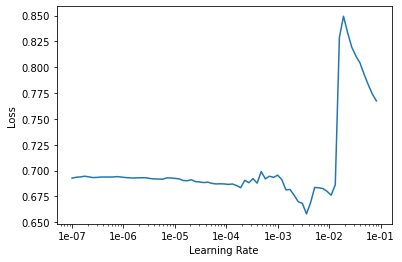

In [301]:
lr_finder.plot()

In [0]:
model = build_model()

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
epochs = 10
lr = 2e-3
steps = np.ceil(total_train  / batch_size) * epochs
lr_schedule = OneCycleScheduler(lr, steps)

In [305]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[lr_schedule]
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 15 steps, validate for 7 steps
Epoch 1/10
15/15 [==============================] - 8s 507ms/step - loss: 0.7045 - accuracy: 0.5224 - val_loss: 0.7020 - val_accuracy: 0.4967
Epoch 2/10
15/15 [==============================] - 7s 492ms/step - loss: 0.6541 - accuracy: 0.5807 - val_loss: 0.6328 - val_accuracy: 0.6775
Epoch 3/10
15/15 [==============================] - 7s 497ms/step - loss: 0.5844 - accuracy: 0.6859 - val_loss: 0.6306 - val_accuracy: 0.6730
Epoch 4/10
15/15 [==============================] - 7s 491ms/step - loss: 0.5038 - accuracy: 0.7441 - val_loss: 0.5922 - val_accuracy: 0.6964
Epoch 5/10
15/15 [==============================] - 7s 495ms/step - loss: 0.4299 - accuracy: 0.7874 - val_loss: 0.6111 - val_accuracy: 0.6853
Epoch 6/10
15/15 [==============================] - 8s 503ms/step - loss: 0.3619 - accuracy: 0.8307 - val_loss: 0.6352 - val_accuracy: 0.6908
Epoch 7/10
15/15 [==============================] - 8s 502ms/step - loss: 0.2918 - accuracy: 0.8638 - val_l

We can now compare this to just running a model without the above procedures.

In [0]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [308]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 15 steps, validate for 7 steps
Epoch 1/10
15/15 [==============================] - 8s 506ms/step - loss: 1.0118 - accuracy: 0.5064 - val_loss: 0.6915 - val_accuracy: 0.4967
Epoch 2/10
15/15 [==============================] - 7s 486ms/step - loss: 0.6791 - accuracy: 0.5032 - val_loss: 0.6712 - val_accuracy: 0.5000
Epoch 3/10
15/15 [==============================] - 7s 485ms/step - loss: 0.6338 - accuracy: 0.5951 - val_loss: 0.6299 - val_accuracy: 0.6462
Epoch 4/10
15/15 [==============================] - 7s 488ms/step - loss: 0.5817 - accuracy: 0.6757 - val_loss: 0.6191 - val_accuracy: 0.6317
Epoch 5/10
15/15 [==============================] - 7s 493ms/step - loss: 0.5371 - accuracy: 0.7137 - val_loss: 0.5945 - val_accuracy: 0.6897
Epoch 6/10
15/15 [==============================] - 7s 491ms/step - loss: 0.4771 - accuracy: 0.7532 - val_loss: 0.6115 - val_accuracy: 0.6719
Epoch 7/10
15/15 [==============================] - 7s 483ms/step - loss: 0.4288 - accuracy: 0.7927 - val_l

We can see the 1-cycle policy does indeed allow for quicker convergence.